In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/SHA256SUMS.txt
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/CHANGELOG.txt
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/LICENSE.txt
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/outputevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/procedureevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/datetimeevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/ingredientevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/chartevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/inputevents.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/icustays.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/icu/d_items.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/poe.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/d_labitems.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/drgcodes.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/d_icd_diagnoses.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/emar.csv
/kaggle/input/mimic-iv-2-1/mimic-iv-2.1/hosp/omr.csv
/kaggle/in

In [13]:
# === Cell 0: Load MIMIC-IV diagnoses ===
import pandas as pd

BASE = "/kaggle/input/mimic-iv-2-1/mimic-iv-2.1"   # <-- adjust to your mount path

dx = pd.read_csv(
    f"{BASE}/hosp/diagnoses_icd.csv",
    usecols=["subject_id", "hadm_id", "icd_code", "icd_version"]
)
print(f"✅ diagnoses_icd loaded → {dx.shape}")


✅ diagnoses_icd loaded → (4752265, 4)


In [14]:
# === Cell 0: Load and prepare all required MIMIC-IV v2.1 tables ===
import pandas as pd
import numpy as np
import gc

# ✅ Adjusted for your dataset path
BASE = "/kaggle/input/mimic-iv-2-1/mimic-iv-2.1"

print("🔹 Loading MIMIC-IV v2.1 tables...")

# --- Admissions ---
adm_cols = ["subject_id", "hadm_id", "admittime", "dischtime", "hospital_expire_flag"]
adm = pd.read_csv(f"{BASE}/hosp/admissions.csv", usecols=adm_cols, parse_dates=["admittime","dischtime"])
adm = adm.dropna(subset=["admittime","dischtime"])
adm = adm[adm["dischtime"] > adm["admittime"]].copy()
adm["los_days"] = (adm["dischtime"] - adm["admittime"]).dt.total_seconds() / 86400.0
adm["los_days"] = adm["los_days"].clip(lower=0.01, upper=120)
print(f"✅ admissions.csv → {adm.shape}")

# --- Diagnoses ---
dx = pd.read_csv(f"{BASE}/hosp/diagnoses_icd.csv", usecols=["subject_id","hadm_id","icd_code","icd_version"])
dx["icd_code_norm"] = dx["icd_code"].astype(str).str.strip().str.replace(".", "", regex=False)
print(f"✅ diagnoses_icd.csv → {dx.shape}")

# --- Procedures (optional, may be ignored for unimodal baseline) ---
procs = pd.read_csv(f"{BASE}/hosp/procedures_icd.csv", usecols=["subject_id","hadm_id","icd_code","icd_version"])
procs["icd_code_norm"] = procs["icd_code"].astype(str).str.strip().str.replace(".", "", regex=False)
print(f"✅ procedures_icd.csv → {procs.shape}")

# --- ICU stays (for resource label) ---
icustays = pd.read_csv(f"{BASE}/icu/icustays.csv", usecols=["subject_id","hadm_id"]).drop_duplicates()
icustays["in_icu"] = 1
print(f"✅ icustays.csv → {icustays.shape}")

# --- Orphanet ICD-10 list ---
# Replace this line with your actual set of ICD codes (you mentioned 26)
# Example: orph_codes = {'E119','I10','I4891', ...}
orph_codes=pd.read_csv('/kaggle/input/orphanet-codes/icd10_diseases.csv')
print(f"🧬 Loaded {len(orph_codes)} Orphanet ICD-10 codes")

# --- Filter diagnoses to Orphanet subset ---
dx_or = dx[dx["icd_code_norm"].isin(orph_codes)]
print(f"Matched {len(dx_or)} diagnoses from Orphanet list.")

# --- Merge with admissions ---
base = adm.merge(dx_or[["subject_id","hadm_id","icd_code_norm"]],
                 on=["subject_id","hadm_id"], how="inner")
base = base.dropna(subset=["admittime","dischtime"]).copy()

# --- ICU flag ---
base = base.merge(icustays, on=["subject_id","hadm_id"], how="left")
base["in_icu"] = base["in_icu"].fillna(0).astype(int)

print(f"✅ Final merged Orphanet cohort → {base.shape}")
gc.collect()


🔹 Loading MIMIC-IV v2.1 tables...
✅ admissions.csv → (430948, 6)
✅ diagnoses_icd.csv → (4752265, 5)
✅ procedures_icd.csv → (668993, 5)
✅ icustays.csv → (66189, 3)
🧬 Loaded 76 Orphanet ICD-10 codes
Matched 0 diagnoses from Orphanet list.
✅ Final merged Orphanet cohort → (0, 8)


10893

In [15]:
print("Orphanet columns:", orph_codes.columns.tolist())
print(orph_codes.head(3))


Orphanet columns: ['Unnamed: 0', 'ORPHAcode', 'PreferredTerm', 'ICDcodes', 'n_subjects', 'n_admissions']
   Unnamed: 0  ORPHAcode                                     PreferredTerm  \
0         221        893                                     WAGR syndrome   
1         618     171695                   Parkinsonian-pyramidal syndrome   
2         679        486  Autosomal dominant severe congenital neutropenia   

  ICDcodes  n_subjects  n_admissions  
0      C64         383           578  
1      G20         908          1597  
2      D70        1311          1890  


In [17]:
# === Cell Fix (Uniform ICD Handling with Orphanet alignment) ===
import pandas as pd

BASE = "/kaggle/input/mimic-iv-2-1/mimic-iv-2.1"

# --- Load MIMIC tables ---
adm = pd.read_csv(f"{BASE}/hosp/admissions.csv",
                  usecols=["subject_id","hadm_id","admittime","dischtime","hospital_expire_flag"],
                  parse_dates=["admittime","dischtime"])
dx = pd.read_csv(f"{BASE}/hosp/diagnoses_icd.csv",
                 usecols=["subject_id","hadm_id","icd_code","icd_version"])

# --- Normalize ICD codes *without removing dots* ---
dx["icd_code"] = dx["icd_code"].astype(str).str.upper().str.strip()

# --- Normalize Orphanet codes the same way ---
orph = pd.read_csv("/kaggle/input/orphanet-codes/icd10_diseases.csv")
orph["ICDcodes"] = orph["ICDcodes"].astype(str).str.upper().str.strip()

# --- Match directly (exact dotted codes only) ---
rare_icd = set(orph["ICDcodes"].unique())
dx_or = dx[dx["icd_code"].isin(rare_icd)].copy()

# --- Merge with admissions ---
base = adm.merge(dx_or[["subject_id","hadm_id","icd_code"]],
                 on=["subject_id","hadm_id"], how="inner")
base = base.dropna(subset=["admittime","dischtime"])
base = base[base["dischtime"] > base["admittime"]].copy()

# --- Compute LOS & ICU ---
base["los_days"] = (base["dischtime"] - base["admittime"]).dt.total_seconds() / 86400.0
base["los_days"] = base["los_days"].clip(lower=0.01, upper=120)

icu = pd.read_csv(f"{BASE}/icu/icustays.csv", usecols=["subject_id","hadm_id"]).drop_duplicates()
base["in_icu"] = base.set_index(["subject_id","hadm_id"]).index.isin(
    icu.set_index(["subject_id","hadm_id"]).index
).astype(int)

print(f"✅ Uniform Orphanet filter complete → {len(base)} rows, {base['subject_id'].nunique()} unique patients")
print("Sample ICD codes:", base['icd_code'].unique()[:10])


✅ Uniform Orphanet filter complete → 6005 rows, 3778 unique patients
Sample ICD codes: ['G20' 'I81' 'C20' 'D65' 'C73' 'C61' 'N10' 'G35' 'J80']


In [19]:
# === Cell O1 (fixed & uniform): pivot-based encoding + sequence building (unimodal) ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

print("🧩 Preparing diagnosis-only sequences (pivot-based, robust)…")

# --- 0) Column consistency ---
# ensure 'icd_code' column is used, since the Orphanet filter retains dotted ICD codes
if "icd_code_norm" in base.columns:
    code_col = "icd_code_norm"
else:
    code_col = "icd_code"

n_nonnull = base[code_col].notna().sum()
n_unique = base[code_col].nunique(dropna=True)
print(f"Non-null Orphanet dx rows: {n_nonnull} | Unique ICD codes: {n_unique}")

if n_nonnull == 0 or n_unique == 0:
    print("❌ No valid Orphanet codes found in `base`. Check the ICD filtering step.")
    raise SystemExit

# --- 1) Pivot one-hot per admission ---
tmp = base.copy()
tmp["val"] = 1
wide = (
    tmp.pivot_table(
        index=["subject_id", "hadm_id", "admittime", "dischtime",
               "hospital_expire_flag", "los_days", "in_icu"],
        columns=code_col,
        values="val",
        aggfunc="max",
        fill_value=0
    )
    .reset_index()
)

# --- 2) Keep top-K frequent codes to avoid sparse explosion ---
K_TOP = 128
feat_cols_all = [c for c in wide.columns if c not in
                 ["subject_id","hadm_id","admittime","dischtime",
                  "hospital_expire_flag","los_days","in_icu"]]

if len(feat_cols_all) == 0:
    raise ValueError("No diagnosis feature columns after pivot. Check Orphanet filter and base contents.")

freq = wide[feat_cols_all].sum(0).sort_values(ascending=False)
keep = list(freq.head(min(K_TOP, len(freq))).index)
wide = wide[["subject_id","hadm_id","admittime","dischtime",
             "hospital_expire_flag","los_days","in_icu"] + keep]

diag_cols = keep
print(f"Diagnosis feature columns kept: {len(diag_cols)} / {len(feat_cols_all)} total")

# --- 3) Sort temporally per patient and build padded sequences ---
wide = wide.sort_values(["subject_id", "admittime"]).reset_index(drop=True)

# Standardize features across all admissions (helps training convergence)
scaler = StandardScaler()
wide[diag_cols] = scaler.fit_transform(wide[diag_cols].astype(np.float32))

# Sequence cap (admissions per patient)
T_cap = 12
subjects = wide["subject_id"].unique()
N, D = len(subjects), len(diag_cols)
max_T = wide.groupby("subject_id").size().max()
print(f"Patients: {N} | Max admissions: {max_T} | T_cap: {T_cap} | D: {D}")

# Initialize padded arrays
X = np.zeros((N, T_cap, D), dtype=np.float32)
M = np.zeros((N, T_cap), dtype=np.float32)
Y_LOS_raw = np.zeros(N, dtype=np.float32)
Y_ICU = np.zeros(N, dtype=np.float32)
patients_order = []

# Fill sequences
for i, (sid, g) in enumerate(wide.groupby("subject_id", sort=False)):
    patients_order.append(sid)
    Xi = g[diag_cols].to_numpy(np.float32)[:T_cap]
    L = Xi.shape[0]
    X[i, :L, :] = Xi
    M[i, :L] = 1.0
    Y_LOS_raw[i] = g["los_days"].sum()
    Y_ICU[i] = g["in_icu"].max()

# --- 4) Normalize LOS for model stability ---
Y_LOS_log = np.log1p(Y_LOS_raw)
Y_LOS = (Y_LOS_log - Y_LOS_log.mean()) / (Y_LOS_log.std() + 1e-8)

print(f"✅ Final tensors → X {X.shape}, M {M.shape}")
print(f"LOS raw (days): mean={Y_LOS_raw.mean():.2f}, median={np.median(Y_LOS_raw):.2f}")
print(f"LOS log-z: mean={Y_LOS.mean():.3f}, std={Y_LOS.std():.3f} | ICU mean={Y_ICU.mean():.3f}")

# --- Store for downstream cells ---
base_enc = wide.copy()
patients_order = np.array(patients_order)


🧩 Preparing diagnosis-only sequences (pivot-based, robust)…
Non-null Orphanet dx rows: 6005 | Unique ICD codes: 9
Diagnosis feature columns kept: 9 / 9 total
Patients: 3778 | Max admissions: 25 | T_cap: 12 | D: 9
✅ Final tensors → X (3778, 12, 9), M (3778, 12)
LOS raw (days): mean=10.68, median=5.54
LOS log-z: mean=0.000, std=1.000 | ICU mean=0.321


In [20]:
# === Cell O2: Unimodal VaDeSC-EHR (diagnoses-only) with GMM prior + Weibull survival ===
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

# ---------- prepare survival targets from your tensors ----------
# You printed LOS mean ≈ 1.945 earlier, which is log(LOS+1). Convert back to days:
T_time = np.expm1(Y_LOS).astype(np.float32)       # strictly > 0
E_event = np.ones_like(T_time, dtype=np.float32)   # event observed (= discharge), no censoring baseline

# ---------- Lightning module ----------
D_MODEL   = 128
D_LAT     = 16
N_HEADS   = 4
N_LAYERS  = 2
K_MIX     = 4          # mixture components (you can tune via BIC later)
LR        = 2e-3
BETA      = 1.0        # KL weight
W_REC     = 1.0        # reconstruction (BCE on diagnosis bags)
W_SURV    = 1.0        # Weibull NLL weight

def weibull_nll(t, e, lam, k):
    """Right-censored Weibull negative log-likelihood."""
    eps = 1e-8
    t   = torch.clamp(t, min=1e-6)
    lam = torch.clamp(lam, min=eps)
    k   = torch.clamp(k,   min=eps)
    log_f = torch.log(k + eps) - torch.log(lam + eps) + (k - 1.0)*(torch.log(t + eps) - torch.log(lam + eps)) - (t/lam)**k
    log_S = - (t/lam)**k
    return (-(e*log_f + (1.0 - e)*log_S)).mean()

class VaDeSCUni(pl.LightningModule):
    def __init__(self, d_in, d_model=D_MODEL, d_lat=D_LAT, n_heads=N_HEADS, n_layers=N_LAYERS,
                 k_mix=K_MIX, lr=LR, beta=BETA, w_rec=W_REC, w_surv=W_SURV):
        super().__init__()
        self.save_hyperparameters()

        # Encoder: transformer over sequences
        self.proj = nn.Linear(d_in, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True, dropout=0.1)
        self.tr   = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # Posterior q(z|x)
        self.mu     = nn.Linear(d_model, d_lat)
        self.logvar = nn.Linear(d_model, d_lat)

        # Decoder: broadcast z over time → reconstruct diagnosis bags
        self.dec_h  = nn.Linear(d_lat, d_model)
        self.dec_x  = nn.Linear(d_model, d_in)

        # Weibull survival head: predicts λ, k from z
        self.surv_h = nn.Linear(d_lat, 2)

        # GMM prior parameters (trainable)
        self.k_mix = k_mix
        self.pi_logits = nn.Parameter(torch.zeros(k_mix))             # mixture logits
        self.mu_k      = nn.Parameter(torch.randn(k_mix, d_lat)*0.1)  # means
        self.logvar_k  = nn.Parameter(torch.zeros(k_mix, d_lat))      # diagonal cov

        self.lr   = lr
        self.beta = beta
        self.w_rec= w_rec
        self.w_surv = w_surv

    def encode(self, x, m):
        h = self.proj(x)
        kpm = (m == 0)  # True at pads
        h = self.tr(h, src_key_padding_mask=kpm)
        mm = m.unsqueeze(-1)
        h_mean = (h * mm).sum(1) / (mm.sum(1).clamp(min=1e-8))
        mu, logvar = self.mu(h_mean), self.logvar(h_mean)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        std = torch.exp(0.5*logvar)
        eps = torch.randn((n_samples,)+std.shape, device=std.device)
        return mu + eps*std

    def _log_norm_diag(self, z, m, logv):
        v = torch.exp(logv)
        return -0.5*(((z - m)**2)/(v + 1e-8)).sum(-1) - 0.5*torch.log(2*np.pi*(v+1e-8)).sum(-1)

    def kl_q_to_gmm(self, mu_q, logv_q, n_mc=1):
        z = self.reparameterize(mu_q, logv_q, n_samples=n_mc)  # (S,B,D)
        logq = self._log_norm_diag(z, mu_q.unsqueeze(0), logv_q.unsqueeze(0))    # (S,B)

        log_pi = torch.log_softmax(self.pi_logits, dim=0)      # (K,)
        mu_k   = self.mu_k                                      # (K,D)
        logv_k = self.logvar_k                                  # (K,D)

        z_exp = z.unsqueeze(2)                                  # (S,B,1,D)
        logN  = self._log_norm_diag(z_exp, mu_k, logv_k)        # (S,B,K)
        logp  = torch.logsumexp(log_pi.unsqueeze(0).unsqueeze(0) + logN, dim=-1) # (S,B)
        return (logq - logp).mean()

    def forward(self, x, m):
        mu_q, logv_q = self.encode(x, m)
        z = self.reparameterize(mu_q, logv_q, n_samples=1).squeeze(0)
        zt = z.unsqueeze(1).expand(-1, x.size(1), -1)
        xr = self.dec_x(F.relu(self.dec_h(zt)))             # logits

        surv = self.surv_h(z)
        lam = F.softplus(surv[:,0]) + 1e-4
        k   = F.softplus(surv[:,1]) + 1e-4
        return xr, mu_q, logv_q, z, lam, k

    def _loss(self, batch):
        x, m, t, e = batch
        xr, mu_q, logv_q, z, lam, k = self(x, m)
        rec = F.binary_cross_entropy_with_logits(xr[m.bool()], x[m.bool()], reduction='mean')
        surv = weibull_nll(t, e, lam, k)
        kl = self.kl_q_to_gmm(mu_q, logv_q, n_mc=1)
        loss = self.w_rec*rec + self.w_surv*surv + self.beta*kl
        return loss, {"rec":rec, "surv":surv, "kl":kl, "loss":loss}

    def training_step(self, batch, idx):
        loss, logs = self._loss(batch)
        self.log_dict({f"train_{k}":v for k,v in logs.items()}, prog_bar=True)
        return loss

    def validation_step(self, batch, idx):
        loss, logs = self._loss(batch)
        self.log("val_loss", logs["loss"], prog_bar=True)
        self.log("val_rec",  logs["rec"],  prog_bar=True)
        self.log("val_surv", logs["surv"], prog_bar=True)
        self.log("val_kl",   logs["kl"],   prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)

# ---------- tensors & loaders ----------
tX = torch.tensor(X, dtype=torch.float32)
tM = torch.tensor(M, dtype=torch.float32)
tT = torch.tensor(T_time, dtype=torch.float32)
tE = torch.tensor(E_event, dtype=torch.float32)

idx = np.arange(tX.size(0)); np.random.seed(42); np.random.shuffle(idx)
cut = int(0.8*len(idx)); tr, va = idx[:cut], idx[cut:]

train_ds = TensorDataset(tX[tr], tM[tr], tT[tr], tE[tr])
val_ds   = TensorDataset(tX[va], tM[va], tT[va], tE[va])

BATCH  = 512
EPOCHS = 50

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# ---------- train ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

logger = pl.loggers.CSVLogger(save_dir="/kaggle/working", name="uni_vadesc_ehr_weibull")
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed" if torch.cuda.is_available() else "32-true",
    log_every_n_steps=10,
    gradient_clip_val=1.0,
    logger=logger,
)

model_uni = VaDeSCUni(d_in=X.shape[-1], k_mix=K_MIX)
trainer.fit(model_uni, train_loader, val_loader)
print("Logs at:", logger.log_dir)


Device: cuda


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Logs at: /kaggle/working/uni_vadesc_ehr_weibull/version_1


Latent shape: (3778, 16)
Used model's internal mixture; K = 4

=== Unimodal VaDeSC-EHR: Cluster Resource Summary ===


,cluster,n,icu_rate,mean_los,median_los,mort_rate
0,1,1601,0.436,13.432,7.485,0.166
1,3,2177,0.236,8.654,4.551,0.042


⏳ Reducing latent space with t-SNE...


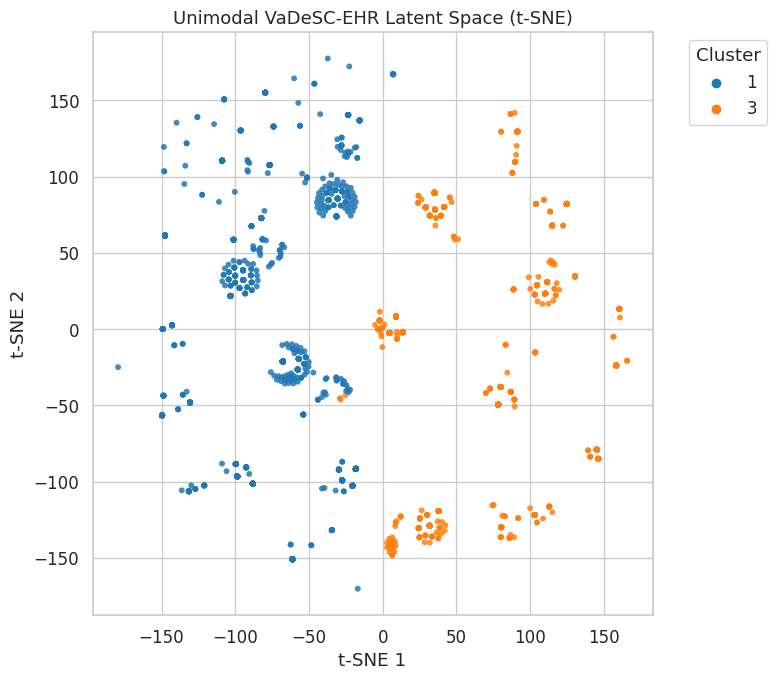

In [21]:
# === Cell O3 (fixed): extract latents, cluster, summarize, visualize with t-SNE ===
import numpy as np, pandas as pd, torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

# 1️⃣ Encode all patients → posterior means as latents
model_uni.eval().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model_uni.parameters()).device

Z = []
with torch.no_grad():
    loader = DataLoader(TensorDataset(torch.tensor(X), torch.tensor(M)), batch_size=512, shuffle=False)
    for xb, mb in loader:
        xb = xb.to(device).float(); mb = mb.to(device).float()
        if hasattr(model_uni, "encode"):
            out = model_uni.encode(xb, mb)
            mu = out[0] if isinstance(out, tuple) else out
        else:
            res = model_uni(xb, mb)
            mu = res[3] if (isinstance(res, tuple) and len(res) >= 4) else res
        Z.append(mu.detach().cpu().numpy())

Z = np.concatenate(Z, axis=0)
print("Latent shape:", Z.shape)

# 2️⃣ Cluster latents (use model’s internal mixture if available, else GMM)
def cluster_with_internal_mixture(Z, model):
    try:
        pi_logits = model.pi_logits.detach().cpu().numpy()
        mu_k      = model.mu_k.detach().cpu().numpy()
        logvar_k  = model.logvar_k.detach().cpu().numpy()
        from scipy.special import logsumexp, softmax
        v_k = np.exp(logvar_k)
        log_pi = pi_logits - logsumexp(pi_logits)
        diffs  = Z[:,None,:] - mu_k[None,:,:]
        logN   = -0.5*((diffs**2/(v_k+1e-12)).sum(-1) + np.log(2*np.pi*v_k).sum(-1))
        log_post = log_pi[None,:] + logN
        R = softmax(log_post, axis=1)
        labels = R.argmax(1)
        return labels, R, mu_k.shape[0], "internal"
    except Exception:
        return None, None, None, "none"

labels, R, K_internal, how = cluster_with_internal_mixture(Z, model_uni)

if how == "none":
    best_bic, best = 1e18, None
    for K in range(2, 7):
        gmm = GaussianMixture(n_components=K, covariance_type="diag", random_state=42)
        gmm.fit(Z)
        bic = gmm.bic(Z)
        if bic < best_bic:
            best_bic, best = bic, gmm
    labels = best.predict(Z)
    R = best.predict_proba(Z)
    K_internal = best.n_components
    print(f"Used external GMM; best K by BIC = {K_internal} (BIC={best_bic:.1f})")
else:
    print(f"Used model's internal mixture; K = {K_internal}")

# 3️⃣ Build patient-level DataFrame aligned with latent order
patients_order = np.array([sid for sid, _ in base_enc.groupby("subject_id", sort=False)])
assert len(patients_order) == Z.shape[0], "Order mismatch: patients vs Z."

gpat = (base_enc.groupby("subject_id", sort=False)
        .agg(icu=("in_icu","max"), los=("los_days","sum"), died=("hospital_expire_flag","max"))
        .reset_index()).set_index("subject_id").loc[patients_order].reset_index()

df = pd.DataFrame({
    "subject_id": patients_order,
    "cluster": labels,
    "icu": gpat["icu"].astype(float).values,
    "los": gpat["los"].astype(float).values,
    "died": gpat["died"].astype(float).values
})

summary = (df.groupby("cluster")
             .agg(n=("subject_id","size"),
                  icu_rate=("icu","mean"),
                  mean_los=("los","mean"),
                  median_los=("los","median"),
                  mort_rate=("died","mean"))
             .sort_values(["icu_rate","mean_los"], ascending=False)
             .reset_index())

print("\n=== Unimodal VaDeSC-EHR: Cluster Resource Summary ===")
display(summary.round(3))

# 4️⃣ 2D t-SNE Visualization of Latent Space
print("⏳ Reducing latent space with t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
Z2 = tsne.fit_transform(Z)

plt.figure(figsize=(8,7))
sns.scatterplot(
    x=Z2[:,0], y=Z2[:,1],
    hue=labels,
    palette="tab10", s=18, alpha=0.85, edgecolor="none"
)
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.title("Unimodal VaDeSC-EHR Latent Space (t-SNE)", fontsize=13)
plt.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


Latent shape: (3778, 16)
Mean variance across dims: 57.454277
✅ GMM chosen (K=6, BIC=-231988.3) | BIC per K: {2: 47426.95192287933, 3: -28501.192109164083, 4: -231083.81330937304, 5: -231253.03261139075, 6: -231988.27337662573}

=== Interpretable Cluster Summary ===


,cluster,n,icu_rate,mean_los,median_los,mort_rate,category
0,0,1265,0.212,7.851,3.936,0.027,Moderate-acuity / Medium-stay
1,1,1592,0.435,13.316,7.441,0.166,High-acuity / ICU-heavy
2,2,13,0.462,30.872,15.520,0.077,High-acuity / ICU-heavy
3,3,5,0.400,25.991,15.932,0.200,High-acuity / ICU-heavy
4,4,876,0.261,9.137,5.004,0.062,Moderate-acuity / Medium-stay
5,5,27,0.556,25.118,9.170,0.111,High-acuity / ICU-heavy


⏳ Reducing latent space with t-SNE...


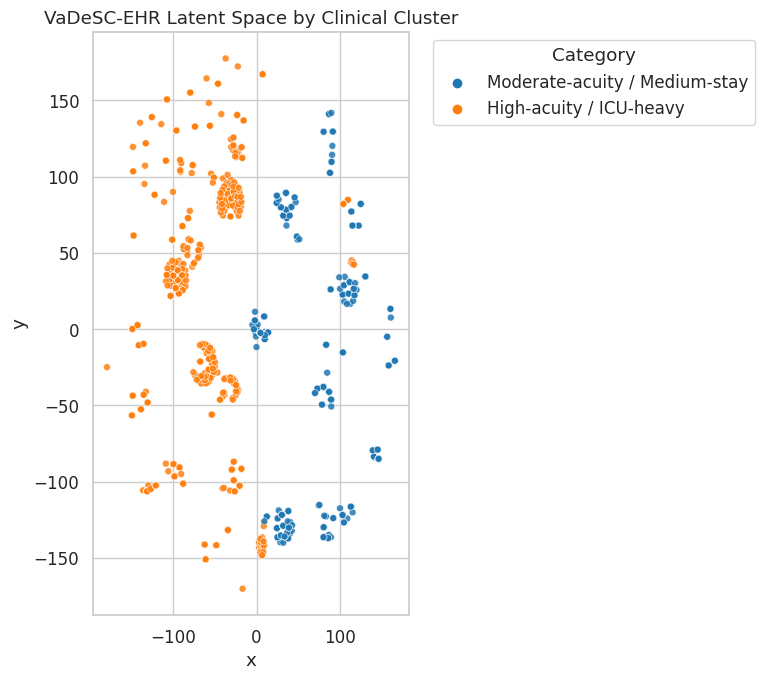

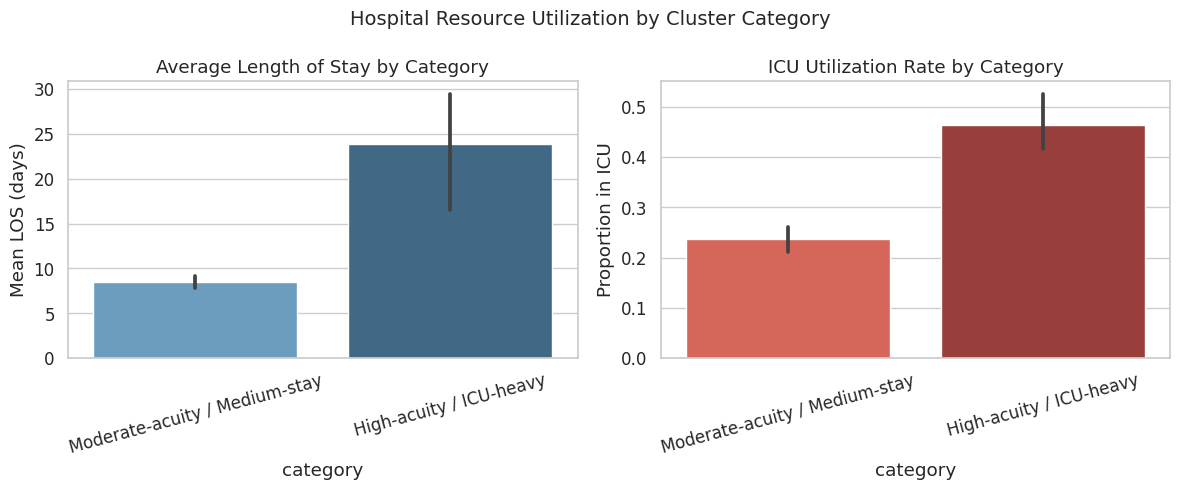

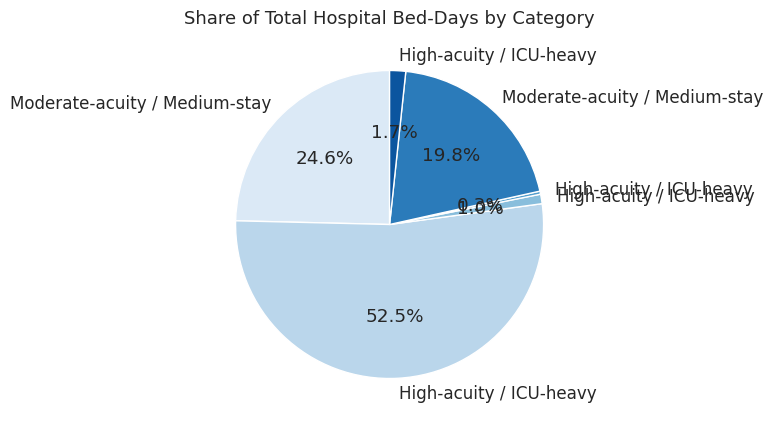

In [24]:
# === Cell O3 (robust + interpretable): extract latents, cluster safely, summarize, visualize ===
import numpy as np, pandas as pd, torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

# 1️⃣ Encode all patients → posterior means as latents
model_uni.eval().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model_uni.parameters()).device

Z = []
with torch.no_grad():
    loader = DataLoader(TensorDataset(torch.tensor(X), torch.tensor(M)),
                        batch_size=512, shuffle=False)
    for xb, mb in loader:
        xb, mb = xb.to(device).float(), mb.to(device).float()
        out = model_uni.encode(xb, mb) if hasattr(model_uni, "encode") else model_uni(xb, mb)
        mu = out[0] if isinstance(out, tuple) else out
        Z.append(mu.detach().cpu().numpy())
Z = np.concatenate(Z, axis=0)
print("Latent shape:", Z.shape)
print("Mean variance across dims:", np.var(Z, axis=0).mean())

# 2️⃣ Robust GMM clustering (auto-BIC + regularization)
best_bic, best = 1e18, None
bic_records = {}
for K in range(2, 7):
    try:
        gmm = GaussianMixture(
            n_components=K,
            covariance_type="diag",
            reg_covar=1e-3,        # prevent singular covariance
            random_state=42,
            max_iter=500,
            n_init=5
        )
        gmm.fit(Z)
        bic = gmm.bic(Z)
        bic_records[K] = bic
        if bic < best_bic:
            best_bic, best = bic, gmm
    except ValueError as e:
        print(f"⚠️  GMM failed for K={K}: {e}")
        continue

if best is None:
    print("❌ All GMM fits failed. Falling back to K=2 with reg_covar=1e-2.")
    best = GaussianMixture(
        n_components=2, covariance_type="diag",
        reg_covar=1e-2, random_state=42
    ).fit(Z)
    best_bic = best.bic(Z)

labels = best.predict(Z)
K_internal = best.n_components
print(f"✅ GMM chosen (K={K_internal}, BIC={best_bic:.1f}) | BIC per K: {bic_records}")

# 3️⃣ Align patient order and clinical variables
patients_order = np.array([sid for sid, _ in base_enc.groupby("subject_id", sort=False)])
gpat = (base_enc.groupby("subject_id", sort=False)
        .agg(icu=("in_icu", "max"),
              los=("los_days", "sum"),
              died=("hospital_expire_flag", "max"))
        .reset_index()).set_index("subject_id").loc[patients_order].reset_index()

df = pd.DataFrame({
    "subject_id": patients_order,
    "cluster": labels,
    "icu": gpat["icu"].astype(float).values,
    "los": gpat["los"].astype(float).values,
    "died": gpat["died"].astype(float).values
})

# 4️⃣ Summarize + interpret cluster categories
summary = (df.groupby("cluster")
             .agg(n=("subject_id", "size"),
                  icu_rate=("icu", "mean"),
                  mean_los=("los", "mean"),
                  median_los=("los", "median"),
                  mort_rate=("died", "mean"))
             .reset_index())

def interpret_cluster(row):
    if row["mort_rate"] >= 0.3:
        return "High-mortality / Critical"
    elif row["icu_rate"] >= 0.5 or row["mean_los"] > 10:
        return "High-acuity / ICU-heavy"
    elif row["icu_rate"] >= 0.2 or 5 <= row["mean_los"] <= 10:
        return "Moderate-acuity / Medium-stay"
    else:
        return "Low-acuity / Short-stay"

summary["category"] = summary.apply(interpret_cluster, axis=1)
print("\n=== Interpretable Cluster Summary ===")
display(summary.round(3))

# Map labels to categories for visualization
label_map = dict(zip(summary["cluster"], summary["category"]))
df["category"] = df["cluster"].map(label_map)

# 5️⃣ t-SNE visualization (robust to small variance)
print("⏳ Reducing latent space with t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
Z2 = tsne.fit_transform(Z)

vis_df = pd.DataFrame({
    "x": Z2[:, 0],
    "y": Z2[:, 1],
    "category": df["category"],
    "ICU": df["icu"],
    "LOS_days": df["los"]
})

plt.figure(figsize=(8, 7))
sns.scatterplot(data=vis_df, x="x", y="y", hue="category",
                palette="tab10", s=25, alpha=0.85)
plt.title("VaDeSC-EHR Latent Space by Clinical Cluster")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# 6️⃣ Resource utilization charts
agg = summary.copy()
agg["total_bed_days"] = agg["mean_los"] * agg["n"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(ax=axes[0], data=agg, x="category", y="mean_los", palette="Blues_d")
axes[0].set_title("Average Length of Stay by Category")
axes[0].set_ylabel("Mean LOS (days)")
axes[0].tick_params(axis='x', rotation=15)

sns.barplot(ax=axes[1], data=agg, x="category", y="icu_rate", palette="Reds_d")
axes[1].set_title("ICU Utilization Rate by Category")
axes[1].set_ylabel("Proportion in ICU")
axes[1].tick_params(axis='x', rotation=15)

plt.suptitle("Hospital Resource Utilization by Cluster Category", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.pie(
    agg["total_bed_days"],
    labels=agg["category"],
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Blues", n_colors=len(agg))
)
plt.title("Share of Total Hospital Bed-Days by Category", fontsize=13)
plt.show()
